![alt text](https://zewailcity.edu.eg/main/images/logo3.png)
# Cie 425 Video encoder project
## Dr. Mahmoud Abdelaziz
* Noureldin Mohamed	201900311
* Ezzat Eisawy			201901195
* Mahmoud Shelil 		201900967

In [4]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 52.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from PIL import Image
from IPython.display import Image as Img
import numpy as np
from numpy import zeros
from matplotlib import image
from matplotlib import pyplot as plt
from numpy import cos
from numpy.core.umath import pi
from numpy.linalg import norm
from numpy import uint8
from numpy import asarray
from numpy import array
from queue import PriorityQueue
from decimal import Decimal
from decimal import getcontext
import threading
import cv2

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    from google.colab.patches import cv2_imshow
    COLAB = True
else:
    print('Not running on CoLab')
    COLAB = False

Not running on CoLab


#### Utility functions for image processing
##### The following block contains functions for :
* Image devision , Combination
* Generating basis , DCT and IDCT
* Quantization and deuantization
* zigzag conversion
* Run length encode and decode

In [3]:
def devide_image(img ) :
    ''' Takes an image and devides it to n*m sub images... n and m are the nearest integer scale of 8 x 8
    returns the sub images (as an array), n and and m'''
    img_array = asarray(img)
    if len(img_array.shape) > 2:    
        img_array = img_array[:,:,0]
    n,m = img_array.shape
    n ,m=  int(n/8) ,int(m/8)
    res_devided = []
    for i in range(n) :
        for j in range(m) :
            res_devided.append(img_array[i*8:(i+1)*8,j*8:(j+1)*8])
    return res_devided ,n ,m

def combine_image(blocks ,n,m , limit   = True) :
    ''' Takes an array of 8x8 blocks to be combined to a nx8,mx8 image'''
    final_image = zeros((n*8,m*8))
    idx =0
    for i in range(n) :
        for j in range(m) :
            final_image[i*8:(i+1)*8,j*8:(j+1)*8] = blocks[idx]
            idx +=1
    if limit :
        return final_image.astype(uint8)
    return final_image.astype(int)
    
    ########################
def create_basis_mat() :
    ''' Creating a matrix containing another basis matrices for all u and v to be used in block DCT'''
    basis_mat = np.empty(shape=(8,8) ,dtype= object)
    for u in range(8) :
        for v in range(8) :
            # for x in range(8) :
            #     for y in range(8) :
            #         basis[x,y] = (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi))
            ''' The next line is similar to the previous two for loops'''
            basis = np.fromfunction(lambda x, y: (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi)), (8, 8), dtype=float)
            basis_mat[u,v] = basis
    return basis_mat

def dct8_image(image_part : np.array ,basis_mat :np.array = None) :
    ''' 8x8 image array --> 8x8 array of the same image after DCT
    .. the function can be provided with the basis matrix for faster execution '''
    basis = np.zeros(shape=(8,8))
    res = np.zeros(shape=(8,8))
    for u in range(8) :
        for v in range(8) :
            if basis_mat is not None:   # if basis matrix is provided , use it .. else create basis for each u ,v
                basis = basis_mat[u,v]
            else :
                basis = np.fromfunction(lambda x, y: (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi)), (8, 8), dtype=float)

            res[u,v] = np.sum (image_part*basis)   # sum of each element of basis multiplied to the corresponding element in image
    
    res[0,:] =  res[0,:]/2 
    res[:,0] =  res[:,0]/2
    res[:,:] =  res[:,:]/16
    return res 

def idct8_image(image_part : np.array ,basis_mat :np.array = None , limit = True) :
    ''' Similar to DCT ,8x8 DCT image array --> 8x8 array of the original image '''
    basis = np.zeros(shape=(8,8))
    res = np.zeros(shape=(8,8))
    for u in range(8) :
        for v in range(8) :
            if basis_mat is not None: # if basis matrix is provided , use it .. else create basis for each u ,v
                basis = basis_mat[u,v]
            else :
                basis = np.fromfunction(lambda x, y: (cos((1/16)* (2*x +1)*u*pi) *  cos((1/16)* (2*y +1)*v*pi)), (8, 8), dtype=float)
            res += image_part[u,v] * basis
    if limit :
        res = np.clip(res ,0,255)
        return res.astype(uint8) ;
    return res.astype(int) ; 

def create_q_table( q_type = 'luminance',q_factor : int = 50) :
    if q_type == 'luminance':
        qm = np.array([
                [16, 11 ,10 ,16, 24 ,40 ,51  ,61 ] ,
                [12 ,12 ,14, 19, 26, 58, 60  ,55 ] ,
                [14, 13 ,16 ,24 ,40, 57, 69  ,56]  ,
                [14, 17, 22, 29, 51, 87, 80  ,62 ] , 
                [18, 22, 37 ,56, 68 ,109,103 ,77 ] ,
                [24 ,35, 55 ,64, 81, 104,113 ,92 ] ,  
                [49 ,64 ,78 ,87, 103,121,120 ,101] ,
                [72 ,92 ,95 ,98, 112,100,103 ,99]
                ])
    elif q_type == 'chrominance' :
        qm = np.array([
                [17,  18,  24,  47,  99,  99,  99,  99],
                [18,  21,  26,  66,  99,  99,  99,  99],
                [24,  26,  56,  99,  99,  99,  99,  99],
                [47,  66,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99],
                [99,  99,  99,  99,  99,  99,  99,  99]
                ])
    s = 5000/q_factor if (q_factor < 50) else 200-q_factor*2
    qm_f = np.floor((qm*s - 50)/100)
    return qm_f


    ########################
def quantize(im : np.array , qm_f) :
    res = (np.round(im/qm_f )).astype(np.int32)
    return res

def dequantize(im : np.array ,qm_f) :
    res = (np.round(im.astype(float)*qm_f.astype(float) )).astype(np.int32)
    return res
#####################

def to_zigzag(im : np.array) :
    ''' Input 8x8 matrix --> output 64 array with zigzag pattern '''
    res = np.zeros(64 , dtype = np.int32)
    x = 0
    y =0
    dr = 1;
    for i in range(32) :
        res[i] = im[y,x]
        x += dr
        y -= dr
        if y == -1 :
            y = 0
            dr = -1
        if x == -1 :
            x = 0
            dr = 1
            
    x = 7
    y = 7
    dr = 1
    for i in range (32) :
        res[-(i+1)] = im[y,x]
        x -= dr
        y += dr
        if y == 8 :
            y = 7
            dr = -1
        if x == 8 :
            x = 7
            dr = 1
    
    return res;

def from_zigzag(inpt : np.array)  :
    ''' Input  64 array with zigzag pattern --> output 8x8 matrix '''
    res = np.zeros((8,8) , dtype = np.int32)
    x = 0
    y =0
    dr = 1;
    for i in range(32) :
        res[y,x] = inpt[i]
        x += dr
        y -= dr
        if y == -1 :
            y = 0
            dr = -1
        if x == -1 :
            x = 0
            dr = 1
            
    x = 7
    y = 7
    dr = 1
    for i in range (32) :
        res[y,x] = inpt[-(i+1)]
        x -= dr
        y += dr
        if y == 8 :
            y = 7
            dr = -1
        if x == 8 :
            x = 7
            dr = 1
    
    return res;
###################
def run_len_encode(inpt : np.array) :
    res = np.zeros(2*len(inpt) , dtype = np.int32)
    res_idx = 0;
    idx =0
    while idx < len(inpt) :
        res[res_idx] = inpt[idx]
        res_idx += 1
        if inpt[idx] == 0 :
            cnt = 1
            idx +=1
            while idx < len(inpt)  and inpt[idx] ==0 :
                cnt += 1
                idx +=1
            res[res_idx] = cnt
            res_idx += 1
        else :
            idx +=1
    return res[0:res_idx]

def run_len_decode(inpt : np.array) :
    res = []
    i =0
    while i < len(inpt) :
        res.append(inpt[i])
        if inpt[i] == 0 :
            i +=1
            for j in range(inpt[i] -1)  :
                res.append(0)
        i+=1
    return   np.array(res)

#### Huffman Encode/ Decode functions
##### The following block contains an implementation of a binary tree node , Frequency per symbol calculation function and  huffman encode/decode functions 

In [4]:
class node :
    """ A class we will use to represent a symbol node in the tree """
    left  = None
    right = None
    freq = None
    symbol = None

    def __init__(self ,freq = None, symbol = None, left = None , right = None ) -> None:
        self.left = left
        self.right = right
        self.symbol = symbol
        self.freq = freq
    
    def __lt__(self, nxt):
        """ Ovveriding the "Less than" class method so that the nodes can be compared by frequency and can be used easily in pq """
        return self.freq < nxt.freq
         
def huffman_code(freqs : dict) -> dict :
    """ Function the takes a dict of frequencies and returns  a dict of corrosponding coding """
    result_dict = freqs.copy()
    q = PriorityQueue()
    for symbol , freq in freqs.items() :
        q.put(node(symbol=symbol , freq= freq))
    node_right = None
    
    while  q.qsize() > 1 :    # q has at least 2 nodes left
        node_right = q.get()
        node_left = q.get()
        parent = node(freq= node_right.freq + node_left.freq , symbol= None , left= node_left , right= node_right )   
        q.put(parent)
        node_right = parent
    

    # traverse the tree to the coding , left --> 1 , right --> 0 , we will use recursion
    def traverse_node(nd :node ,init_code :str = '') :
        if nd.left :
            traverse_node(nd.left ,init_code+ '1')
        if nd.right :
            traverse_node(nd.right ,init_code+ '0')
        if not ( nd.left or nd.right) :  # node for symbol
            result_dict[nd.symbol] = init_code


    traverse_node(node_right)
    return result_dict   

def calculate_probs(text ) :
    """ returns a dictionary of characters in the input text and their probabilities """
    data_set = set(text)
    res_dict = dict()
    for i in data_set :
        res_dict[i] = 0
    
    for i in text :
        res_dict[i] +=1
    
    total = len(text)
    for key,val in res_dict.items():
        res_dict[key] = val/total
    
    return res_dict

def huff_encode_stream(text  , code_table : dict) :
    """ returns a string corresponding the input text with each character mapped to a value in the code table   """
    res = ''
    for s in text :
        if s  in code_table.keys() :
            res += str(code_table[s])
    return res

def huff_decode_stream(text  , code_table : dict) :
    ''' Decode string/array of '1' and '0' from a code table , uses a binary tree to decode '''
    # construct tree for code table
    parent = node()
    for key ,val in code_table.items() :
        chld = parent
        for bt in val :
            if bt == '1' :
                if not chld.left: chld.left = node()
                chld = chld.left
            else :
                if not chld.right: chld.right = node()
                chld = chld.right 
        chld.symbol = key
    res =[]

    # decode input stream using the tree
    chld:node = parent
    for ltr in  text :
        if ltr =='1' :
            chld = chld.left
        else :
            chld = chld.right
        if not chld.symbol == None :
            
            res.append(chld.symbol)
            chld = parent
    return np.array(res)


#### Arithmetic coding functions
##### The following block contains functions for Arithmetic encoding and decoding
* The default block length for a complete code encoding is 10 bits
* Any block length greater than 10 MAY cause cause precision problems that will result in a crash

In [5]:
getcontext().prec  = 500 # 500 precision points

def dec2bin(num ,limit) :    # decimal to binary string with limit
    res = ''
    for _ in range(limit) :
        num *=2;
        if int(num) ==0 :
            res += '0'
        else :
            res += '1'
            num -= 1

    return res

def get_symbol_range(symbol_prob : dict , code_word   )   :   
    """  A functtion to get the low and high limits from a word whose symbols are contained within the dictionry
    of probabilities    """
    
    smbl = code_word[0]
    low = Decimal(0)
    high = Decimal(sum(symbol_prob.values()))
    for smbl in code_word :
        hght = Decimal(high- low)
        for key ,val in symbol_prob.items() :
            val = Decimal(val)
            if key == smbl :
                high = low   +hght* val
                break;
            low += hght* val
        
    return low , high


def encode_with_range(low  , high   ) :
    """ A function to represent the limits into a binary code (as string)
    """
    num = (low + high) /2
    limit = int(np.ceil(np.log2(1/float(high - low)) +1)) 

    return dec2bin(num ,limit) 


def decode_bin( symbol_prob : dict,  bin_word : str , n : int)  :   
    ''' Decode a binary string to word of n symbols
    '''
    point = Decimal(0)
    for i , val in enumerate(bin_word) :
        point += Decimal(int(val)) * Decimal(2**-(i+1))
    low = Decimal(0)
    high = Decimal(sum(symbol_prob.values()))
    res = np.empty(n , dtype = type(list(symbol_prob.keys())[0]))

    for i in range(n) :  
        hght = high - low
        for key ,val in symbol_prob.items() :
            val = Decimal(val)
            if low +hght*val> point :
                high = low + hght*val
                res[i] = key
                break;
            low += hght* val
    return res

def enocde_arithmetic(symbol_prob : dict , symbol_seq , step = 10 ) : 
    ''' Wrapper for big code arithmetic encoding , default block size is 10
    '''
    code =''
    lens = np.zeros(int(np.ceil(len(symbol_seq)/step) +1) ,dtype = np.int32)
    for i in range(int(np.ceil(len(symbol_seq)/step))) :
        seq = symbol_seq[i*step : (i +1) * step]
        low , high = get_symbol_range(symbol_prob , seq )
        # print(seq)
        # print(low )
        # print(high)
        res =encode_with_range(low  , high)
        code += res
        lens[i] = len(res)

    lens[-1] = len(symbol_seq)  # last element we will save the original sequence length
    return   code , lens

def decode_arithmetic(symbol_prob : dict , code_seq , lens ,step = 10 ) :
    ''' Wrapper for big code arithmetic decoding , default block size is 10
    '''
    result = np.zeros(step*(len(lens) -1) , dtype = np.int32 )
    total = lens[-1]
    lens = lens[:-1]
    idx =0
    for  i,ln in enumerate(lens)  :
        #print(ln)
        seq = code_seq[idx : idx + ln]
        idx = idx + ln
        result[i* step : (i +1) * step] = decode_bin(symbol_prob ,seq , step)

    return result[:total];

#### Two wrapper functions for image encoding & decoding
##### The next two functions for image decoding / encoding utilize the previously defined functions to work on a whole image with an efficient and organized code (kinda)

In [6]:
def encode_image(img  ,q_type = 'luminance',q_factor = 50  , encode_type ='huff') :
    ''' takes input image and quantization table type ('luminance'/'chrominance' ) and value for quality factor
    returns the encoded stream, the image dimensions and the code table '''
    image_parts ,n,m= devide_image(img)  # Devide image into array of arrays
    basis_mat = create_basis_mat()    # create the basis for all u,v = 0 :8

    q_table = create_q_table(q_type ,q_factor);

    dct_blocks = np.array([dct8_image(part,basis_mat) for part in image_parts])   # apply DCT on all parts
    quantized_blocks = np.array([quantize(part ,q_table) for part in dct_blocks])  # Quantize all parts
    zigzag_parts = np.array([to_zigzag(part) for part in quantized_blocks])   # Apply zigzag (2d --> 1d) for all parts 
    length_coded_parts   =  np.array([ run_len_encode(part) for part in zigzag_parts] ,dtype=object)   # aplly run length encoding on all parts
    coded_combined = np.concatenate(length_coded_parts) # Compine all parts intp one continuous array

    if encode_type == 'huff' :
        encode_table = huffman_code(freqs= calculate_probs(coded_combined))  # get the code table for the frequencies of symbols in the stream
        encoded_stream = huff_encode_stream(text= coded_combined ,code_table= encode_table)  # Encode the stream
    elif encode_type == 'arth' :
        probs_dict = calculate_probs(coded_combined)
        encoded_stream , lens = enocde_arithmetic(probs_dict  , coded_combined )
        encode_table = (probs_dict , lens)
        

    return encoded_stream ,n ,m, encode_table   # return results
 
def decode_image(encoded_stream ,n,m , encode_table ,q_type = 'luminance',q_factor = 50  , encode_type ='huff' ,limited = True) :
    
    
    if encode_type == 'huff' :
        decoded_stream = huff_decode_stream(encoded_stream,encode_table)  # Decde the input stream
    elif encode_type == 'arth' :
        probs_dict , lens = encode_table
        decoded_stream = decode_arithmetic(probs_dict, encoded_stream , lens  )

    expanded_full_length = run_len_decode(decoded_stream)   # Expand zeros in the input
    segmented_blocks_1d = np.array([expanded_full_length[i*64 :(i+1)*64] for i in range(int(len(expanded_full_length)/64))])   # Devide the input to n*m/64 64-element arrays
    after_zigzag_parts_2d = np.array([from_zigzag(seg) for seg in segmented_blocks_1d ])   # Apply zigzag (1d --> 2d) for all parts 
    
    q_table = create_q_table(q_type ,q_factor);

    dequantized_parts = np.array([dequantize(part,q_table) for part in after_zigzag_parts_2d])  # Dequantize using qiven parameters
    basis_mat = create_basis_mat()    # create the basis for all u,v = 0 :8
    idct_blocks = np.array([idct8_image(part,basis_mat , limit = limited) for part in dequantized_parts] )  # apply IDCT on all parts
    final_image = combine_image(blocks=idct_blocks , n= n ,m= m , limit= limited)    # Compine all parts to one single image  
    return final_image  # return full image


# Lossless 

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def encode_image_lossless(img):
    """Lossless image encoding using delta encoding and Huffman coding"""
    # Convert image to numpy array
    img_array = np.array(img)
    if len(img_array.shape) > 2:    
        img_array = img_array[:,:,0]  # Convert to grayscale if needed
    
    # Store dimensions
    height, width = img_array.shape
    
    # Store first column for reconstruction
    first_column = img_array[:,0].copy()
    
    # Delta encoding (difference between adjacent pixels)
    delta_encoded = np.zeros_like(img_array)
    delta_encoded[:,0] = img_array[:,0]
    delta_encoded[:,1:] = img_array[:,1:] - img_array[:,:-1]
    
    # Flatten the delta encoded array
    flattened = delta_encoded.flatten()
    
    # Huffman encoding
    huffman_table = huffman_code(calculate_probs(flattened))
    encoded_stream = huff_encode_stream(flattened, huffman_table)
    
    return {
        'stream': encoded_stream,
        'height': height,
        'width': width,
        'huffman_table': huffman_table,
        'first_column': first_column
    }

def decode_image_lossless(encoded_data):
    """Lossless image decoding"""
    # Extract data from encoded dictionary
    height = encoded_data['height']
    width = encoded_data['width']
    huffman_table = encoded_data['huffman_table']
    first_column = encoded_data['first_column']
    
    # Huffman decode
    decoded_data = huff_decode_stream(encoded_data['stream'], huffman_table)
    
    # Reshape to original dimensions
    delta_decoded = decoded_data.reshape(height, width)
    
    # Reconstruct original image from deltas
    reconstructed = np.zeros_like(delta_decoded)
    reconstructed[:,0] = delta_decoded[:,0]  # First column remains unchanged
    
    # Cumulative sum along rows to recover original values
    for i in range(1, width):
        reconstructed[:,i] = reconstructed[:,i-1] + delta_decoded[:,i]
    
    return reconstructed

In [8]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the image (keeping RGB channels)
# original_img = Image.open('./DSC_7597.jpg')  # Remove .convert('L')
# original_array = np.array(original_img)

# # Encode each color channel separately
# encoded_channels = []
# n = m = None
# encode_tables = []

# for channel in range(3):  # RGB channels
#     channel_data = original_array[:,:,channel]
#     encoded_stream, n, m, encode_table = encode_image(
#         img=channel_data,
#         q_type="luminance",
#         q_factor=50,
#         encode_type='huff'
#     )
#     encoded_channels.append(encoded_stream)
#     encode_tables.append(encode_table)

# # Decode each color channel separately
# decoded_channels = []
# for channel in range(3):
#     decoded_channel = decode_image(
#         encoded_stream=encoded_channels[channel],
#         n=n,
#         m=m,
#         encode_table=encode_tables[channel],
#         q_type='luminance',
#         q_factor=50,
#         encode_type='huff',
#         limited=True
#     )
#     decoded_channels.append(decoded_channel)

# # Combine channels into RGB image
# decoded_img = np.stack(decoded_channels, axis=2)

# # Display the results
# plt.figure(figsize=(12, 6))

# # Original image (RGB)
# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(original_array-decoded_img)
# plt.axis('off')

# # Decoded image (RGB)
# plt.subplot(1, 2, 2)
# plt.title('Decoded Image')
# plt.imshow(decoded_img)
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# # Calculate and print compression ratio (considering all channels)
# original_size = original_array.size * original_array.itemsize
# encoded_size = sum(len(channel) for channel in encoded_channels)
# compression_ratio = original_size / encoded_size
# print(f"Compression Ratio: {compression_ratio:.2f}:1")
# print(f"Original Size: {original_size} bytes")
# print(f"Encoded Size: {encoded_size} bytes")

#### Motion vectors getting and compensating functions
* The motion vector function checks the motion in 9 possibilities (same position , up , down , left , right , up left , up right , down left , down right) 
* Best vector is choses by the least square error
* For each image , a matrix of vectors is generated for each block in the image

In [9]:
def get_motion_mat(ref_frame : np.array , next_frame : np.array) :  
    ''' Returns a matrix of vectors for each 8x8 block in the image
    '''
    n,m = ref_frame.shape
    n ,m=  int(n/8) ,int(m/8)
    motion_mat = np.empty(dtype=object ,shape = (n ,m))
    for i in range(n) :
        for j in range(m) :
            min_err =norm(ref_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ] - 
            next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ])   
            motion_mat[i,j] = (0,0)       # no motion
            if i > 0 :
                err = norm(ref_frame[(i-1)*8 : (i ) * 8 ,j*8 : (j +1) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # up block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (-1,0)  # up

            if i > 0 and j >0 :
                err = norm(ref_frame[(i-1)*8 : (i ) * 8 ,(j-1)*8 : (j ) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # up left block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (-1,-1)  # up left

            if i > 0 and j < m -1 :
                err = norm(ref_frame[(i-1)*8 : (i ) * 8 ,(j+1)*8 : (j +2 ) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # up right block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (-1,1)  # up right

            if i < n -1 :
                err = norm(ref_frame[(i+1)*8 : (i +2 ) * 8 ,(j)*8 : (j +1) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # down block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (1,0)  # down

            if i < n -1 and j >0 :
                err = norm(ref_frame[(i+1)*8 : (i+2 ) * 8 ,(j-1)*8 : (j ) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # down left block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (1,-1)  # down left

            if i < n -1 and j < m -1 :
                err = norm(ref_frame[(i+1)*8 : (i +2 ) * 8 ,(j+1)*8 : (j +2 ) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # down right block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (1,1)  # down right

            if j > 0 :
                err = norm(ref_frame[(i)*8 : (i +1 ) * 8 ,(j-1)*8 : (j ) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # left block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (0 , -1)  # left

            if j < m -1 :
                err = norm(ref_frame[(i)*8 : (i +1 ) * 8 ,(j+1)*8 : (j +2 ) * 8 ] - 
                next_frame[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ]) # right block
                if err < min_err : 
                    min_err = err
                    motion_mat[i,j] = (0 , 1)  # right

    return motion_mat

def apply_motion(ref_frame , motion_mat) :
    '''
     Constructs a new frame using the refrence frame and the motion vectors matrix
    '''
    n,m = ref_frame.shape
    n ,m=  int(n/8) ,int(m/8)
    next_constructed = np.zeros(shape = (n *8 ,m *8) ,dtype= np.uint8)
    for i in range(n) :
        for j in range(m) :
            ii = i + motion_mat[i,j][0]    # y axis
            jj = j + motion_mat[i,j][1]    # x axis
            next_constructed[i*8 : (i +1) * 8 ,j*8 : (j +1) * 8 ] = ref_frame[ii*8 : (ii +1) * 8 ,jj*8 : (jj +1) * 8 ]  

    return next_constructed
   

#### Video encoding function
* Uses the CV2 video library to read /write video
* The idea of operation is to read the frame , constructs the encoded version and rewrites it to an output file
* The functions stores only two frames in the memory (current and refrence)
* Refrence frame is encoded version of the previous current frame and is updated every frame

In [10]:
def encode_vid(video_path ,out_name,runtime_secs = 2 , rgb = True , encode_type ='huff'  , display_frames = True , q_factor = 50) :

    # Init video capture and write classes
    cv2.destroyAllWindows()
    vid_cap = cv2.VideoCapture(video_path)
    fps    = vid_cap.get(cv2.CAP_PROP_FPS)
    length = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))    

    # Read first frame
    _,first_frame = vid_cap.read()
    n,m ,_= first_frame.shape
    n ,m=  int(n/8) ,int(m/8)

    total_expected_length_bits = n*m*64 * runtime_secs*fps * 3 *8;

    expected_coded_length = 0

    # Init the refrence frame by encoding and decoding the first frame
    ref_frame = np.zeros(shape = (n*8,m*8 , 3) , dtype = np.uint8)
    for i in range(3) :
        encoded_stream ,n ,m, huff_table = encode_image(first_frame[:,:,i], q_factor= q_factor , encode_type = encode_type)
        expected_coded_length += len(encoded_stream)    
        ref_frame[:,:,i]  = decode_image(encoded_stream ,n,m , huff_table , q_factor= q_factor , encode_type = encode_type)


    writer = cv2.VideoWriter(out_name, 
                            cv2.VideoWriter_fourcc(*'MJPG'),
                            fps, ( m *8 , n *8 ) )

    # save first frame  to disk
    writer.write(ref_frame)
    f0 = 0;    # frame counter

    

    while(vid_cap.isOpened() and f0 <= fps * runtime_secs):
        # Capture frame-by-frame
        print(f'Frame {f0} out of {int(fps * runtime_secs)}')
        ret, frame = vid_cap.read()         
        if ret == True:     # If faliure return
            frame = frame[0:n*8 , 0 :m*8 ,:]   # crop frame to multiples of 8
            f0 += 1
            constructed_frame = np.zeros(shape = (n*8,m*8 , 3) , dtype = np.uint8)   # Buffer matrix to store the constructed frame
            motion_vects = get_motion_mat(ref_frame =ref_frame[:,:,0]  , next_frame = frame[:,:,0])   # get motion vectors with respect to channel 0
            code_len_buffer = np.zeros(3)


            # Encoding the motion vectors
            motion_vects_flattened = motion_vects.flatten()   # covert to 1d
            
            h_table = huffman_code(calculate_probs(motion_vects_flattened)) 
            encoded_stream = huff_encode_stream(motion_vects_flattened ,h_table)  # encoding the motion vectors
            
            expected_coded_length += len(encoded_stream)    # add the encoded motion vectors length
            decoded_motion = huff_decode_stream(encoded_stream ,code_table=h_table)   # decode motion vectors

            # reshape to 2d
            motion_vects = np.empty(dtype = object , shape = (n,m))
            idx = 0
            for i in range(n) :
                for j in range(m) :
                    motion_vects[i,j] =   decoded_motion[idx]
                    idx +=1
            
            def encode_channel(i) :   # encode color channel
                # get moved predicted frame using the motion vectors and refrence frame
                moved_frame =  apply_motion(motion_mat= motion_vects ,ref_frame= ref_frame[:,:,i])   
                # Calculate residuals
                resids = - moved_frame.astype(np.int32) + frame[:,:,i].astype(np.int32)

                # Encode residuals
                encoded_stream ,n ,m, huff_table = encode_image(resids , q_factor= q_factor , encode_type = encode_type)

                # Measure the coded stream length
                code_len_buffer[i] = len(encoded_stream)

                # Decode to get the residuals back
                decoded_resids = decode_image(encoded_stream ,n,m , huff_table ,limited= False ,
                                              q_factor= q_factor , encode_type = encode_type)
                
                # construct current frame
                constructed_frame[:,:,i] =(np.clip( moved_frame.astype(np.int32) +
                    decoded_resids.astype(np.int32) ,0,255)).astype(np.uint8)


            # Each colr channel will be handeled by a thread
            t1 = threading.Thread(target=encode_channel, args=(0,))
            t2 = threading.Thread(target=encode_channel, args=(1,))
            t3 = threading.Thread(target=encode_channel, args=(2,))

            t1.start();t2.start();t3.start() 

            t1.join();t2.join();t3.join() 

            #Update expected code Length ( sum of the length of each color channel stream)
            expected_coded_length += np.sum(code_len_buffer)
            # Update refrence frame
            ref_frame = constructed_frame
            # Save frame to disk
            writer.write(constructed_frame)

            if display_frames :
                if not COLAB :     # cv2.imshow doesnt run on google colab
                    cv2.imshow('Frame', constructed_frame)
                else :
                    cv2_imshow( constructed_frame)
                cv2.waitKey(20)
     
    # Break the loop if frame read faliure
        else:    
            break


    # Release resources  
    vid_cap.release()
    writer.release()
    cv2.destroyAllWindows()

    # Print results
    print('Quantization table used :')
    print(create_q_table( q_factor = q_factor))
    print('Done')
    print(f'Total expected Length {total_expected_length_bits} bit')
    print(f'Expected encoded length {expected_coded_length} bit')
    print(f'Compression ratio  {total_expected_length_bits/expected_coded_length :.2f} : 1')

# encode video lossless

In [11]:
def encode_vid_lossless(video_path, out_name, runtime_secs=2, display_frames=True):
    """Lossless video encoding using frame-by-frame compression"""
    
    # Init video capture and write classes
    cv2.destroyAllWindows()
    vid_cap = cv2.VideoCapture(video_path)
    fps = vid_cap.get(cv2.CAP_PROP_FPS)
    
    # Read first frame
    _, first_frame = vid_cap.read()
    n, m, _ = first_frame.shape
    n, m = int(n/8), int(m/8)

    total_original_size = 0
    total_compressed_size = 0

    # Init the reference frame by encoding and decoding the first frame
    ref_frame = np.zeros(shape=(n*8, m*8, 3), dtype=np.uint8)
    for i in range(3):
        # Calculate original size
        total_original_size += first_frame[:,:,i].nbytes
        
        # Encode channel using lossless encoding
        encoded_data = encode_image_lossless(Image.fromarray(first_frame[:,:,i]))
        total_compressed_size += len(encoded_data['stream']) / 8
        
        # Decode channel
        ref_frame[:,:,i] = decode_image_lossless(encoded_data)

    writer = cv2.VideoWriter(out_name, 
                           cv2.VideoWriter_fourcc(*'MJPG'),
                           fps, (m*8, n*8))

    # Save first frame to disk
    writer.write(ref_frame)
    f0 = 0  # frame counter

    while(vid_cap.isOpened() and f0 <= fps * runtime_secs):
        print(f'Frame {f0} out of {int(fps * runtime_secs)}')
        ret, frame = vid_cap.read()
        
        if ret == True:
            frame = frame[0:n*8, 0:m*8, :]  # crop frame to multiples of 8
            f0 += 1
            constructed_frame = np.zeros(shape=(n*8, m*8, 3), dtype=np.uint8)
            
            def encode_channel(i):
                # Calculate original size
                
                # Encode channel using lossless encoding
                encoded_data = encode_image_lossless(Image.fromarray(frame[:,:,i]))
                
                # Decode channel
                constructed_frame[:,:,i] = decode_image_lossless(encoded_data)

            # Each color channel will be handled by a thread
            t1 = threading.Thread(target=encode_channel, args=(0,))
            t2 = threading.Thread(target=encode_channel, args=(1,))
            t3 = threading.Thread(target=encode_channel, args=(2,))

            t1.start(); t2.start(); t3.start()
            t1.join(); t2.join(); t3.join()

            # Update reference frame
            ref_frame = constructed_frame
            # Save frame to disk
            writer.write(constructed_frame)

            if display_frames:
                if not COLAB:  # cv2.imshow doesn't run on google colab
                    cv2.imshow('Frame', constructed_frame)
                else:
                    cv2_imshow(constructed_frame)
                cv2.waitKey(20)
        else:
            break

    # Release resources  
    vid_cap.release()
    writer.release()
    cv2.destroyAllWindows()

    # Print results
    print('Done')
    print(f'Total original size: {total_original_size/1024/1024:.2f} MB')
    print(f'Total compressed size: {total_compressed_size/1024/1024:.2f} MB')
    print(f'Compression ratio: {total_original_size/total_compressed_size:.2f}:1')

#### Testing
##### Quantization table to be used :   
* Luminance 

        [16, 11 ,10 ,16, 24 ,40 ,51  ,61 ] ,
        [12 ,12 ,14, 19, 26, 58, 60  ,55 ] ,
        [14, 13 ,16 ,24 ,40, 57, 69  ,56]  ,
        [14, 17, 22, 29, 51, 87, 80  ,62 ] , 
        [18, 22, 37 ,56, 68 ,109,103 ,77 ] ,
        [24 ,35, 55 ,64, 81, 104,113 ,92 ] ,  
        [49 ,64 ,78 ,87, 103,121,120 ,101] ,
        [72 ,92 ,95 ,98, 112,100,103 ,99]
        

##### Quality factor of values (20 , 50 ,85)
* Transformed quantization table using q_factor = 20
     
        [ 39.  27.  24.  39.  59.  99. 127. 152.]
        [ 29.  29.  34.  47.  64. 144. 149. 137.]
        [ 34.  32.  39.  59.  99. 142. 172. 139.]
        [ 34.  42.  54.  72. 127. 217. 199. 154.]
        [ 44.  54.  92. 139. 169. 272. 257. 192.]
        [ 59.  87. 137. 159. 202. 259. 282. 229.]
        [122. 159. 194. 217. 257. 302. 299. 252.]
        [179. 229. 237. 244. 279. 249. 257. 247.]

* Transformed quantization table using q_factor = 50

        [ 15.  10.   9.  15.  23.  39.  50.  60.]
        [ 11.  11.  13.  18.  25.  57.  59.  54.]
        [ 13.  12.  15.  23.  39.  56.  68.  55.]
        [ 13.  16.  21.  28.  50.  86.  79.  61.]
        [ 17.  21.  36.  55.  67. 108. 102.  76.]
        [ 23.  34.  54.  63.  80. 103. 112.  91.]
        [ 48.  63.  77.  86. 102. 120. 119. 100.]
        [ 71.  91.  94.  97. 111.  99. 102.  98.]

* Transformed quantization table using q_factor = 85

        [ 4.  2.  2.  4.  6. 11. 14. 17.]
        [ 3.  3.  3.  5.  7. 16. 17. 16.]
        [ 3.  3.  4.  6. 11. 16. 20. 16.]
        [ 3.  4.  6.  8. 14. 25. 23. 18.]
        [ 4.  6. 10. 16. 19. 32. 30. 22.]
        [ 6. 10. 16. 18. 23. 30. 33. 27.]
        [14. 18. 22. 25. 30. 35. 35. 29.]
        [21. 27. 28. 28. 33. 29. 30. 29.]


# Test image encoding decoding

In [12]:
def compare_compression_methods(image_path):
    # Load image
    original_img = Image.open(image_path).convert('L')  # Convert to grayscale
    original_array = np.array(original_img)
    
    # Calculate dimensions that are multiples of 8
    height, width = original_array.shape
    new_height = (height // 8) * 8
    new_width = (width // 8) * 8
    
    # Crop to multiple of 8
    original_array = original_array[:new_height, :new_width]
    
    print(f"Original dimensions: {height}x{width}")
    print(f"Adjusted dimensions: {new_height}x{new_width}")
    
    # 1. Lossy Compression
    encoded_stream_lossy, n, m, encode_table = encode_image(
        img=original_array,
        q_type="luminance",
        q_factor=50,
        encode_type='huff'
    )
    
    decoded_img_lossy = decode_image(
        encoded_stream=encoded_stream_lossy,
        n=n,
        m=m,
        encode_table=encode_table,
        q_type='luminance',
        q_factor=50,
        encode_type='huff',
        limited=True
    )
    
    # 2. Lossless Compression
    encoded_data = encode_image_lossless(original_array)  # Use cropped array
    decoded_img_lossless = decode_image_lossless(encoded_data)
    
    # Calculate compression ratios
    original_size = original_array.nbytes
    lossy_size = len(encoded_stream_lossy) / 8
    lossless_size = len(encoded_data['stream']) / 8
    
    lossy_ratio = original_size / lossy_size
    lossless_ratio = original_size / lossless_size
    
    # Calculate PSNR for lossy compression
    mse = np.mean((original_array - decoded_img_lossy) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse)) if mse > 0 else float('inf')
    
    # Verify lossless compression
    is_lossless = np.array_equal(original_array, decoded_img_lossless)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image\n{original_array.shape}')
    plt.imshow(original_array, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f'Lossy Compression\nRatio: {lossy_ratio:.2f}:1\nPSNR: {psnr:.2f}dB')
    plt.imshow(decoded_img_lossy, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(f'Lossless Compression\nRatio: {lossless_ratio:.2f}:1\nPerfect: {is_lossless}')
    plt.imshow(decoded_img_lossless, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nOriginal size: {original_size} bytes")
    print(f"Lossy compression ratio: {lossy_ratio:.2f}:1 (PSNR: {psnr:.2f}dB)")
    print(f"Lossless compression ratio: {lossless_ratio:.2f}:1")
    print(f"Lossless verification: {is_lossless}")

Original dimensions: 2483x2483
Adjusted dimensions: 2480x2480


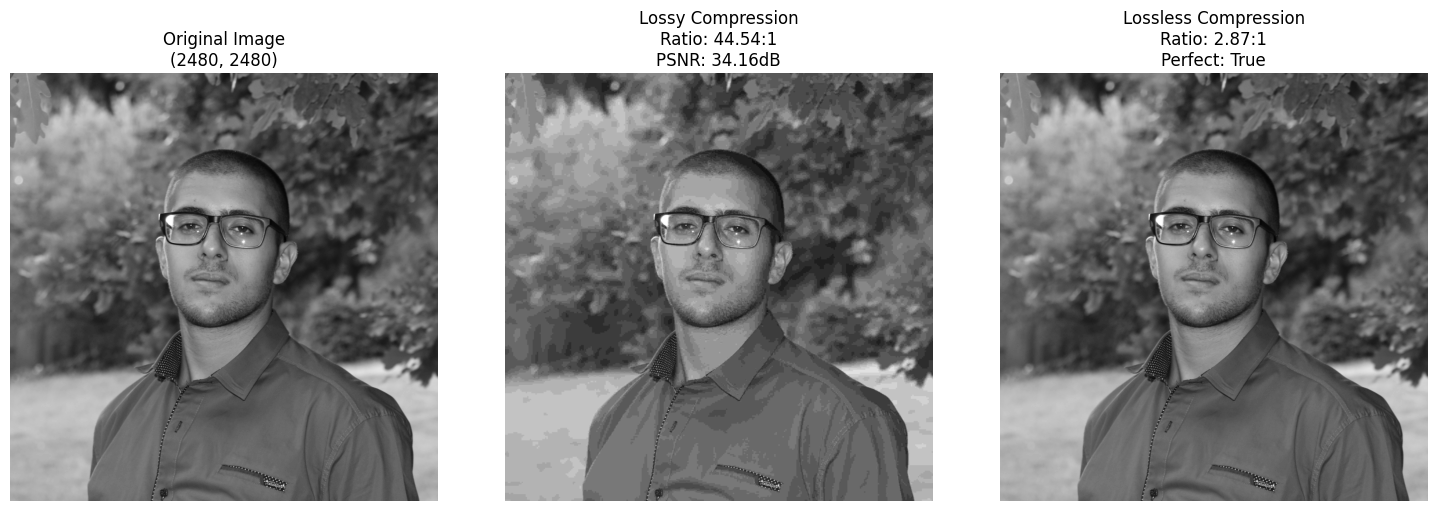


Original size: 6150400 bytes
Lossy compression ratio: 44.54:1 (PSNR: 34.16dB)
Lossless compression ratio: 2.87:1
Lossless verification: True


In [17]:
compare_compression_methods("./imageTest.jpg")

In [13]:
def compare_compression_methods_rgb(image_path):
    # Load image (keeping RGB channels)
    original_img = Image.open(image_path)
    original_array = np.array(original_img)
    
    # Calculate dimensions that are multiples of 8
    height, width = original_array.shape[:2]
    new_height = (height // 8) * 8
    new_width = (width // 8) * 8
    
    # Crop to multiple of 8
    original_array = original_array[:new_height, :new_width]
    
    print(f"Original dimensions: {height}x{width}")
    print(f"Adjusted dimensions: {new_height}x{new_width}")
    
    # Initialize arrays for decoded images
    decoded_img_lossy = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    decoded_img_lossless = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    
    # Process each channel separately
    for channel in range(3):
        # 1. Lossy Compression for current channel
        encoded_stream_lossy, n, m, encode_table = encode_image(
            img=original_array[:,:,channel],
            q_type="luminance",
            q_factor=50,
            encode_type='huff'
        )
        
        decoded_img_lossy[:,:,channel] = decode_image(
            encoded_stream=encoded_stream_lossy,
            n=n,
            m=m,
            encode_table=encode_table,
            q_type='luminance',
            q_factor=50,
            encode_type='huff',
            limited=True
        )
        
        # 2. Lossless Compression for current channel
        encoded_data = encode_image_lossless(original_array[:,:,channel])
        decoded_img_lossless[:,:,channel] = decode_image_lossless(encoded_data)
    
    # Calculate compression ratios
    original_size = original_array.nbytes
    lossy_size = sum(len(encode_image(original_array[:,:,c], q_factor=50)[0]) / 8 for c in range(3))
    lossless_size = sum(len(encode_image_lossless(original_array[:,:,c])['stream']) / 8 for c in range(3))
    
    lossy_ratio = original_size / lossy_size
    lossless_ratio = original_size / lossless_size
    
    # Calculate PSNR for lossy compression (average of all channels)
    mse = np.mean((original_array - decoded_img_lossy) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse)) if mse > 0 else float('inf')
    
    # Verify lossless compression
    is_lossless = np.array_equal(original_array, decoded_img_lossless)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image\n{original_array.shape}')
    plt.imshow(original_array)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f'Lossy Compression\nRatio: {lossy_ratio:.2f}:1\nPSNR: {psnr:.2f}dB')
    plt.imshow(decoded_img_lossy)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title(f'Lossless Compression\nRatio: {lossless_ratio:.2f}:1\nPerfect: {is_lossless}')
    plt.imshow(decoded_img_lossless)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nOriginal size: {original_size} bytes")
    print(f"Lossy compression ratio: {lossy_ratio:.2f}:1 (PSNR: {psnr:.2f}dB)")
    print(f"Lossless compression ratio: {lossless_ratio:.2f}:1")
    print(f"Lossless verification: {is_lossless}")
compare_compression_methods_rgb("./imageTest.jpg")

Original dimensions: 2483x2483
Adjusted dimensions: 2480x2480


# video test

In [ ]:
encode_vid_lossless("./vidTest.mp4", "./losslessVid.avi", runtime_secs=5, display_frames=False)

In [ ]:
video_path = './VID-20230805-WA0015.mp4'
encode_vid(video_path ,'res.avi', 5 , encode_type ='huff')